# Generates the readout's coefficients 

In [2]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

plt.rcParams['figure.figsize'] = 5, 10

import numpy
import sys
import os

from sklearn import linear_model

import save_load_file as slf # https://github.com/ricardodeazambuja/Python-UTILS

import membrane_lowpass_md
membrane_lowpass = membrane_lowpass_md.membrane_lowpass

import time

In [2]:
# Loads the modules and starts the object to be used with the parallel processing iPython stuff...

# Remember to start the clusters:
# https://ipyparallel.readthedocs.org/en/latest/process.html

from ipyparallel import Client

cli = Client()

lbview = cli.load_balanced_view()
# dview = cli[:]

In [3]:
#
# Controls if the results are saved to a file
#

save2file = True

In [4]:
#
# This is the low-pass filter (neuron membrane) applied to the outputs:
membrane_time_constant = 30E-3

# Reducing this value reduces the "memory" of the membrane.

NofN = 20*5*6 # total number of neurons in the output
sim_step_time = 2E-3 #simulation step time (in seconds)

# base_dir = "simulation_data"
# sim_set = "square"

sim_set = "experiment_0001" # basically is the name of the folder where the data is read/saved
base_dir = "simulation_data_00003"

total_trials_available = 100

total_trials = 100 # This value must be the same number of files (trials) generated
                   # in BEE_Simulator_ArmControl_VREP_LSM_DATA-GENERATOR.ipynb

number_of_trajectories = 1

ORIGINAL = True

In [5]:
trial_array = numpy.arange(1,total_trials_available+1,dtype=numpy.int)
# numpy.random.shuffle(trial_array)

In [6]:
#
# Creates a function to read the spikes in a (multiple process) parallel way.
#
@lbview.parallel(block=True)
def reads_files(filename):
    import save_load_file as slf 
    return slf.load_from_file_gz(filename)

# Start from here to train the next liquid!

In [118]:
#
# Here the liquid index is defined
#
# REMEMBER: it goes from ZERO to (number_of_liquids-1)

lsm_i = 3

In [119]:
%%time

# 
# Loads the spikes generated by the liquid with index=lsm_i
# 

filenames = []
output_spikes_simulation = []
for pos_i in xrange(number_of_trajectories):
    for run_i in trial_array[:total_trials]:
        filenames.append(os.getcwd()+"/"+base_dir+"/"+sim_set+"/Joint_Angles"+str(pos_i)+"_LSM_"+str(lsm_i)+"_"+str(run_i)+".gzpickle")
        # The format of simulated_values is (a list of tuples):
        # [
        # current time (in ms),    =>index 1
        # numpy.array with spikes, =>index 2
        # ]
    output_spikes_simulation.append(reads_files.map(filenames))

CPU times: user 795 ms, sys: 290 ms, total: 1.08 s
Wall time: 3.72 s


In [120]:
# 
# Prints some values (first and last time steps), just to make sure it worked...
#

print output_spikes_simulation[0][0][0]

print output_spikes_simulation[0][-1][-1]

[0, array([], dtype=int32)]
[1.9980000000000016, array([  1,   9,  16,  19,  22,  25,  31,  32,  34,  36,  40,  41,  45,
        46,  47,  50,  52,  54,  56,  58,  62,  66,  68,  70,  79,  85,
        90,  91,  94,  96, 107, 116, 122, 123, 125, 130, 156, 160, 161,
       163, 165, 167, 174, 175, 180, 184, 185, 195, 200, 202, 216, 217,
       226, 232, 238, 243, 245, 250, 257, 261, 266, 268, 273, 280, 281,
       287, 288, 290, 296, 300, 301, 308, 310, 312, 321, 322, 329, 330,
       332, 333, 338, 345, 348, 356, 360, 361, 364, 365, 373, 375, 376,
       380, 397, 412, 417, 418, 421, 432, 436, 438, 442, 456, 460, 464,
       491, 494, 502, 510, 511, 519, 525, 526, 528, 532, 533, 539, 540,
       542, 546, 549, 551, 561, 566, 570, 572, 591, 594], dtype=int32)]


## Information about the simulation is extracted directly from data:
```output_spikes_simulation[X] => all the simulated values for the trajectory X+1
output_spikes_simulation[X][Y] => the simulated values for trial Y+1 of the trajectory X+1
output_spikes_simulation[X][Y][Z] => the output spikes for the step Z of the simulated values 
                                     for trial Y+1 of the trajectory X+1
total_trajectories => len(output_spikes_simulation)
total_trials => len(output_spikes_simulation[0]),
total_steps => len(output_spikes_simulation[0][0][:])
sim_step_time => (output_spikes_simulation[0][0][1][0]-output_spikes_simulation[0][0][0][0])```


In [121]:
total_trajectories,total_trials,_total_steps,sim_step_time = len(output_spikes_simulation),\
                                                             len(output_spikes_simulation[0]),\
                                                             len(output_spikes_simulation[0][0]),\
                                                             (output_spikes_simulation[0][0][1][0]-output_spikes_simulation[0][0][0][0])
total_trajectories,total_trials,_total_steps,sim_step_time

(1, 100, 1000, 0.002)

In [122]:
#
# It's important to pay attention to this:
#
total_steps=_total_steps-1
print "total_steps =",total_steps

# The readout is trained to recognise the NEXT value based on the past.
# That's why the first step is missed (there's no past as the network states are random or zero)

total_steps = 999


In [123]:
# Generates the FILTERED (membrane low-pass filter) data to be used with the linear regression
# The first index of the matrix is the trajectory
# Example (each trajectory has 250 steps): 
# linalg_matrix_filtered[0][0:250] => is the first experiment of the first trajectory
# linalg_matrix_filtered[0][250:250*2] => is the second experiment of the first trajectory

avoid_n = 0 # Avoids the avoid_n steps after step=0 (always ignored)
            # This type of LSM receives during the first N steps the correct values before it
            # starts generating the rest of the time series.
            # N = avoid_n+1

# t_idx = 0 # 0=>first trajectory
# e_idx = 0 # 0=>first experiment
linalg_matrix_filtered = numpy.zeros((total_trajectories, total_trials*(total_steps-avoid_n), NofN),dtype=numpy.float)

for t_idx in range(total_trajectories): # goes through all the trajectories
    for e_idx in range(total_trials): # goes through all the trials
        m_v=membrane_lowpass(NofN,membrane_time_constant) # Initialize the membrane for each new trial
        for i in range(1,total_steps): # ignores the first output from the network (noisy, uncorrelated with input)
            if (output_spikes_simulation[t_idx][e_idx][i][1]).size>0:
                m_v.process_spikes(output_spikes_simulation[t_idx][e_idx][i][1],\
                                   output_spikes_simulation[t_idx][e_idx][i][0])
            if i >= avoid_n: #useless as i starts at 1 and avoid_n=1...
                linalg_matrix_filtered[t_idx][(i-avoid_n)+\
                                              (total_steps-avoid_n)*e_idx]=m_v.check_values(i*sim_step_time) # Saves the membrane state at each time step
linalg_matrix_filtered.shape

# This is another good candidate to be vectorized...

(1, 99900, 600)

# Defines the outputs to be learned

In [124]:

original_joints=numpy.zeros((0,4)) #creates an empty array with the right shape...


temp=numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+".npy")
original_joints=numpy.concatenate((original_joints,temp[:1000]))


Now I need to read the CORRECT joint values to be used with the linear regression

In [125]:
# Reads all the experiments to check which range of values is necessary to control the arm.
# At the first step (0) the network always returns zero spikes. So it's impossible to fit anything there, but zero.
# When step=0, the SNN should calculate the next value, or step+1, but because the output is zero, the
# SNN must receive this next step.
# Consequently, the SNN needs the values for step=0 and step=1 before it could be able to generate the next ones.
number_of_joints = 4
joints_all = numpy.zeros((total_steps-avoid_n,number_of_trajectories,number_of_joints),dtype=numpy.float)
for i in xrange(number_of_trajectories):
    joints=numpy.copy(original_joints)
    for j in range(number_of_joints):
        joints_all[:total_steps-avoid_n,i,j]=joints[avoid_n+1:,j] # [2:,j]
joints_all.shape

(999, 1, 4)

## After this point the original data is shorter as I need to offset the values in order to give the network N initial values before it starts generating the curves (N=avoid_n+1).
## Because of this situation the BIAS calculated here is not always the first value, but the N and the RANGES also ignore the first N values.

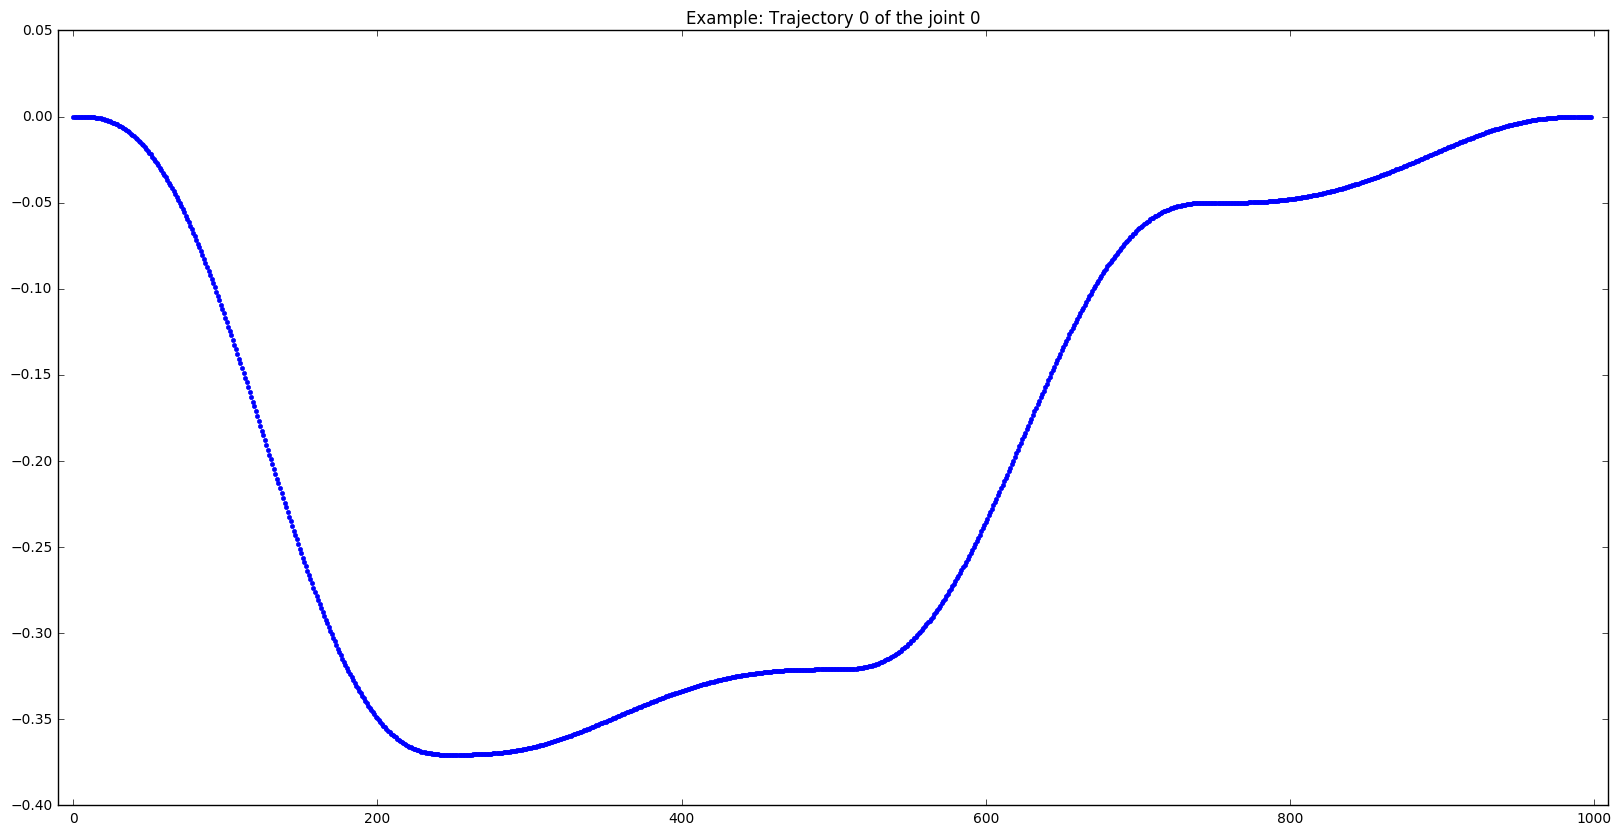

In [126]:
tji=0
ji=0
plt.figure(figsize=(20,10))
plt.plot(joints_all[:,tji,ji]-joints_all[0,tji,ji],'.')
plt.xlim(-10,joints_all.shape[0]+10)
plt.title("Example: Trajectory "+str(tji)+" of the joint "+str(ji))
plt.show()

In [127]:
# Using the idea of starting/finishing with a zero value.
#

y_s0=[]
y_s1=[]
y_e1=[]
y_w1=[]
for tji in range(number_of_trajectories):
    
    # Signal conditioning
    temp_s0=joints_all[:,tji,0]-joints_all[0,tji,0] #extract the bias
    s0_range=(temp_s0.max()-temp_s0.min()) #calculates the range after extracting the bias
    temp_s0=temp_s0/s0_range #normalizes the total range from 0 to 1

    temp_s1=joints_all[:,tji,1]-joints_all[0,tji,1]
    s1_range=(temp_s1.max()-temp_s1.min())
    temp_s1=temp_s1/s1_range

    temp_e1=joints_all[:,tji,2]-joints_all[0,tji,2]
    e1_range=(temp_e1.max()-temp_e1.min())
    temp_e1=temp_e1/e1_range

    temp_w1=joints_all[:,tji,3]-joints_all[0,tji,3]
    w1_range=(temp_w1.max()-temp_w1.min())
    temp_w1=temp_w1/w1_range

    bias_vector = joints_all[0,tji,:]

    print "Bias vector:", bias_vector
    if save2file:
        slf.save_to_file(bias_vector,"./"+base_dir+"/"+sim_set+"/bias_"+str(tji)+".pickle")    

    print "Ranges vector (output):", [s0_range,s1_range,e1_range,w1_range]      
    if save2file:
        slf.save_to_file([s0_range,s1_range,e1_range,w1_range],"./"+base_dir+"/"+sim_set+"/ranges_"+str(tji)+".pickle")
        
    # Here I'm concatenating all trials (repeating the values) in one list for each joint
    for ti in range(total_trials):
        y_s0=numpy.concatenate((y_s0,temp_s0))
        y_s1=numpy.concatenate((y_s1,temp_s1))
        y_e1=numpy.concatenate((y_e1,temp_e1))
        y_w1=numpy.concatenate((y_w1,temp_w1))

Bias vector: [-0.59881717 -0.64028162  2.04201794  0.20936447]
Ranges vector (output): [0.37046223878860474, 0.15775227546691895, 0.59027040004730225, 0.43207989633083344]


In [128]:
y_s0.shape,y_s1.shape,y_e1.shape,y_w1.shape

((99900,), (99900,), (99900,), (99900,))

# Uses the low-pass filtered outputs:

In [129]:
X_matrix=linalg_matrix_filtered    

In [130]:
X_matrix.shape

(1, 99900, 600)

In [131]:
# Prepare the matrix to be used with numpy linear regression:
X_reshaped=X_matrix.reshape(y_s0.shape[0],NofN)

# Creates an empty matrix with an extra collumn with ones (numpy.linalg.lstsq demands this...)
X_reshaped=numpy.ones((X_reshaped.shape[0],X_reshaped.shape[1]+1))

# Writes the values in to the first NofN collumns
X_reshaped[:,:NofN]=X_matrix.reshape(y_s0.shape[0],NofN)


In [132]:
# Now the reshaped matrix has an extra collumn:
X_reshaped.shape

(99900, 601)

In [133]:
X=X_reshaped

In [134]:
numpy.shape(X)[0]*numpy.shape(X)[1]

60039900

In [135]:
X.max(),X.min(),y_s0.max(),y_s0.min(),y_s1.max(),y_s0.min(),y_e1.max(),y_e1.min(),y_w1.max(),y_w1.min()

(8.0111078203233443,
 0.0,
 0.0,
 -1.0,
 0.99006553204737768,
 -1.0,
 0.025994300367137787,
 -0.97400569963286221,
 0.95485924437975744,
 -0.045140755620242536)

In [136]:
X.shape, y_s0.shape

((99900, 601), (99900,))

In [137]:
X[:,-1] # Shows the last column made of ones...

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [138]:
extra_name=str(lsm_i)+"_Modular"

filenames = ["./"+base_dir+"/"+sim_set+"/coefficients_residues_"+str(var_name)+"_linear"+extra_name+".pickle" \
             for var_name in ['s0','s1','e1','w1']]

In [139]:
print filenames[0]

./simulation_data/square/coefficients_residues_s0_linear3_Modular.pickle


In [140]:
%%time
# Non parallel linear regression (trying to solve the pickles problem when I have too many trials (more than 300...))
from sklearn import linear_model

X=X[:,:NofN] # Cuts out the extra ones used only for 

sklg = linear_model.Ridge()
y=numpy.hstack((y_s0.reshape((1,y_s0.shape[0])).T,\
                y_s1.reshape((1,y_s1.shape[0])).T,\
                y_e1.reshape((1,y_e1.shape[0])).T,\
                y_w1.reshape((1,y_w1.shape[0])).T))
sklg.fit(X,y)

for fi in range(4):
    if save2file:
        slf.save_to_file([sklg.coef_[fi],sklg.intercept_[fi]],filenames[fi])
    
[c_s0,r_s0] = slf.load_from_file(filenames[0])
[c_s1,r_s1] = slf.load_from_file(filenames[1])
[c_e1,r_e1] = slf.load_from_file(filenames[2])
[c_w1,r_w1] = slf.load_from_file(filenames[3])

CPU times: user 3.05 s, sys: 169 ms, total: 3.22 s
Wall time: 954 ms


#### Using sklearn I can try a lot of different readouts:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

In [141]:
extra_name=str(lsm_i)+"_Modular"


filenames = ["./"+base_dir+"/"+sim_set+"/coefficients_residues_"+str(var_name)+"_linear"+extra_name+".pickle" \
             for var_name in ['s0','s1','e1','w1']]

[c_s0,r_s0] = slf.load_from_file(filenames[0])
[c_s1,r_s1] = slf.load_from_file(filenames[1])
[c_e1,r_e1] = slf.load_from_file(filenames[2])
[c_w1,r_w1] = slf.load_from_file(filenames[3])

In [142]:
s0_calculated=X_matrix.reshape(y_s0.shape[0],NofN).dot(c_s0)+r_s0
s1_calculated=X_matrix.reshape(y_s1.shape[0],NofN).dot(c_s1)+r_s1
e1_calculated=X_matrix.reshape(y_e1.shape[0],NofN).dot(c_e1)+r_e1
w1_calculated=X_matrix.reshape(y_w1.shape[0],NofN).dot(c_w1)+r_w1

In [143]:
X_matrix.shape

(1, 99900, 600)

In [144]:
# This dictionary is used to automate the figures generation
joints_dict={'s0':(y_s0,s0_calculated),'s1':(y_s1,s1_calculated),'e1':(y_e1,e1_calculated),'w1':(y_w1,w1_calculated) }

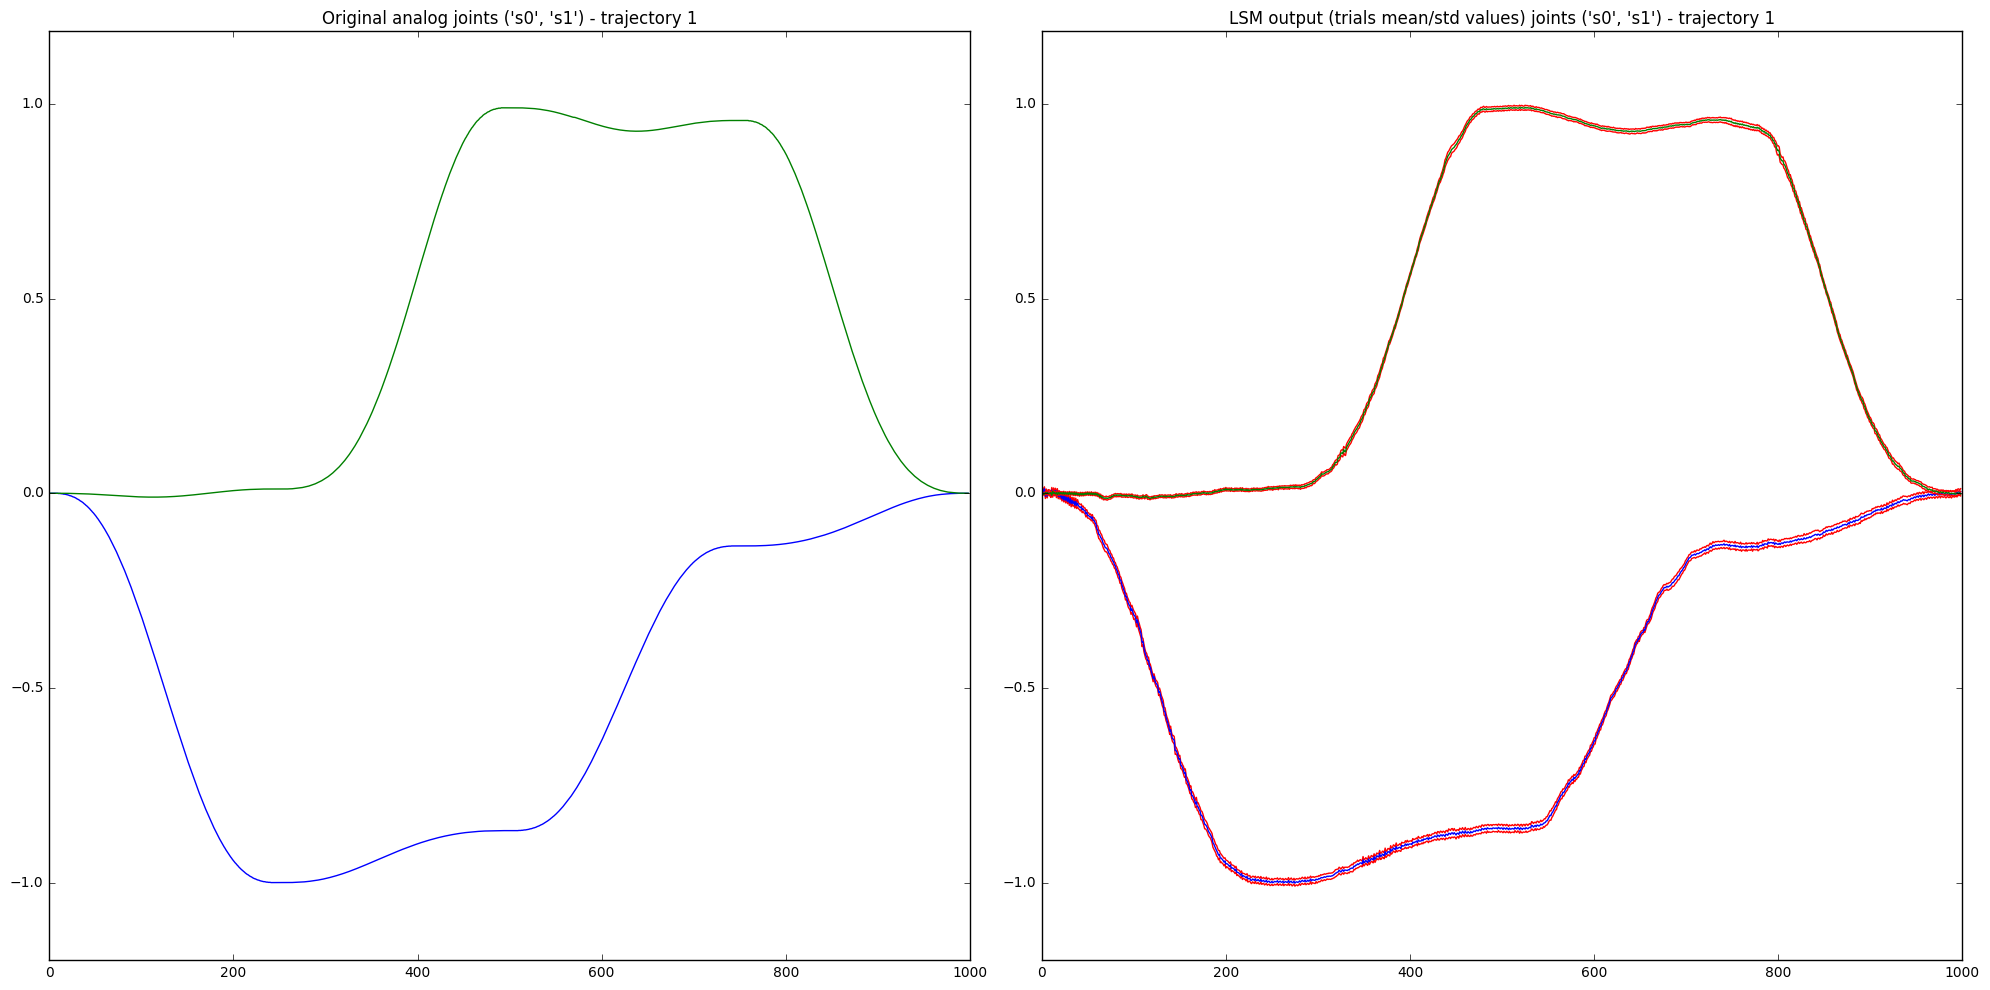

In [145]:
# Plots the inputs and the outputs side-by-side

joints_names = 's0','s1'

y_1 = joints_dict[joints_names[0]][0]
y_2 = joints_dict[joints_names[1]][0]
y1_calculated = joints_dict[joints_names[0]][1]
y2_calculated = joints_dict[joints_names[1]][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset21 = y_2.shape[0]/number_of_trajectories

offset12 = y_1.shape[0]/number_of_trajectories/total_trials
offset22 = y_2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()


    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(y_1[trajectory*(offset11):offset11*trajectory+offset12],'b')
    plt.plot(y_2[trajectory*(offset21):offset21*trajectory+offset22],'g')


    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("Original analog joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)+y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)-y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')    
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0),'b')    
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)+y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')    
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)-y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')        
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0),'g')    
    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("LSM output (trials mean/std values) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

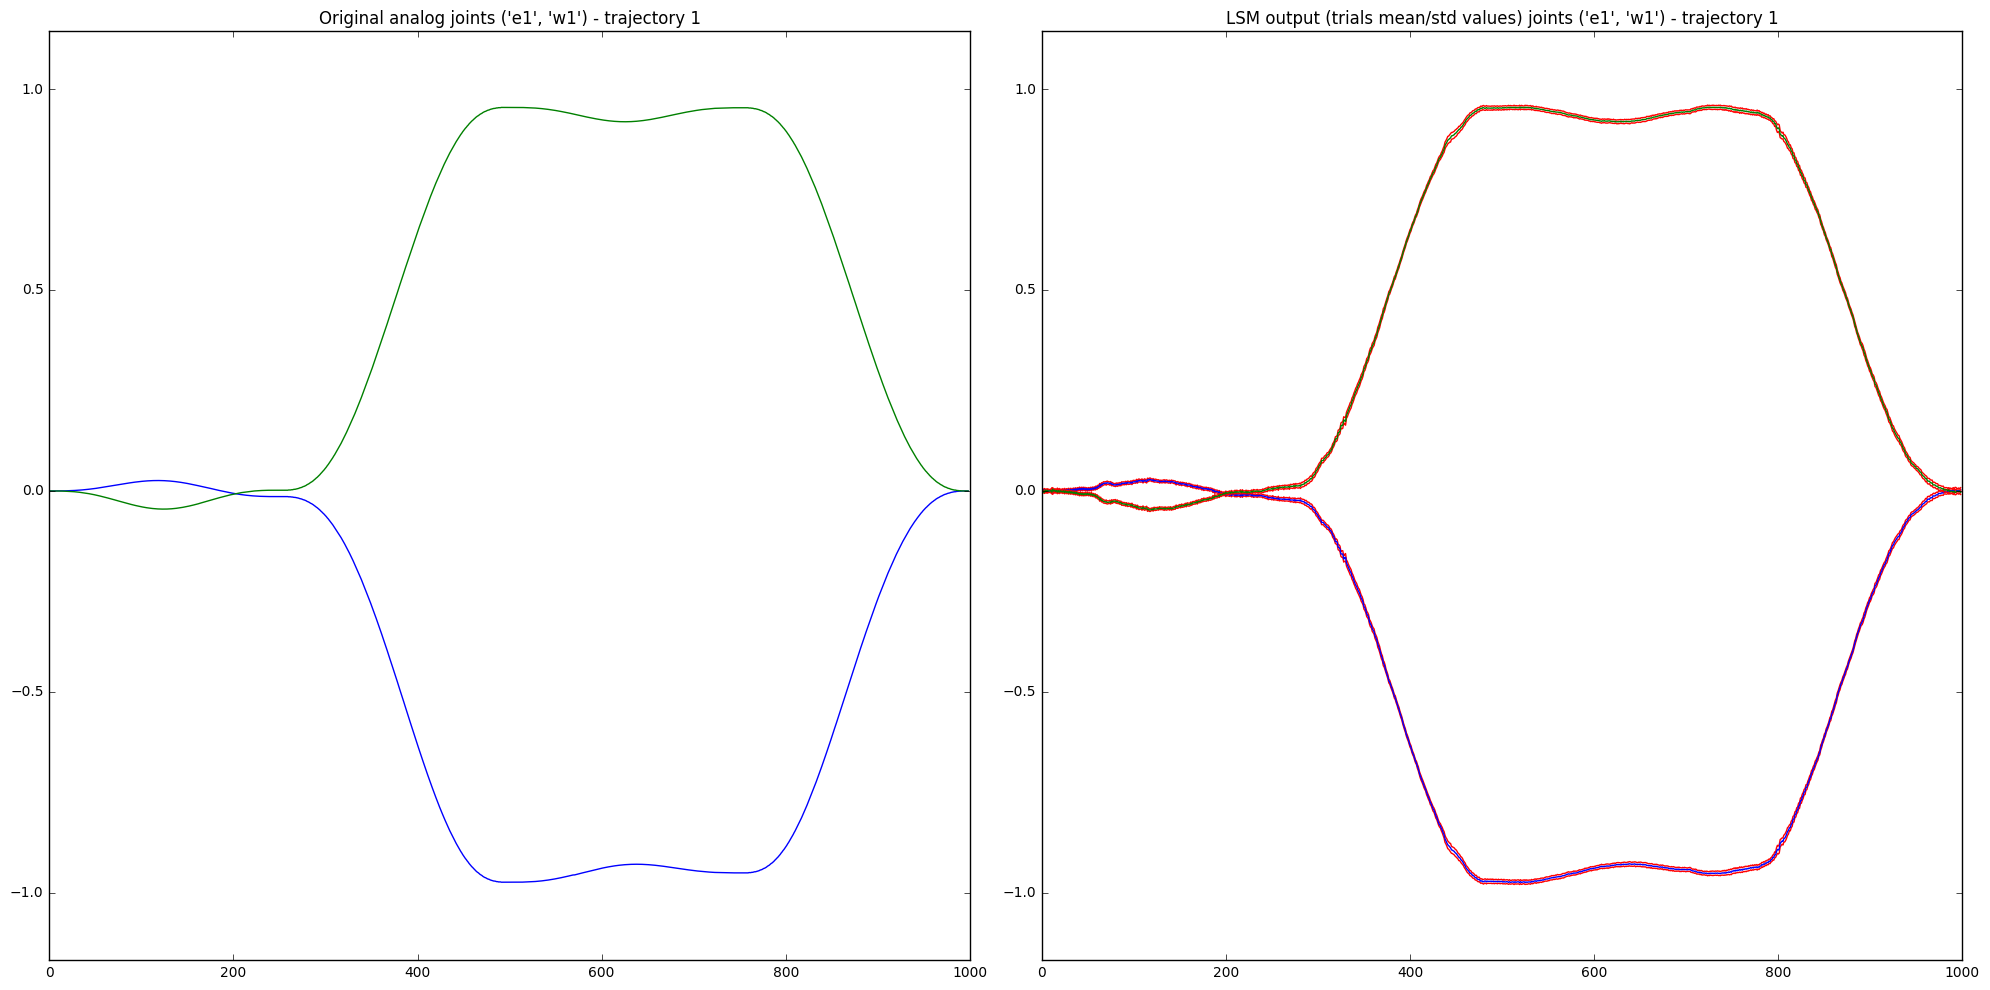

In [146]:
# Plots the inputs and the outputs side-by-side

joints_names = 'e1','w1'

y_1 = joints_dict[joints_names[0]][0]
y_2 = joints_dict[joints_names[1]][0]
y1_calculated = joints_dict[joints_names[0]][1]
y2_calculated = joints_dict[joints_names[1]][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset21 = y_2.shape[0]/number_of_trajectories

offset12 = y_1.shape[0]/number_of_trajectories/total_trials
offset22 = y_2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()


    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(y_1[trajectory*(offset11):offset11*trajectory+offset12],'b')
    plt.plot(y_2[trajectory*(offset21):offset21*trajectory+offset22],'g')


    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("Original analog joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)+y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)-y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')    
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0),'b')    
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)+y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')    
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)-y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')
    plt.plot(y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0),'g')    
    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("LSM output (trials mean/std values) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

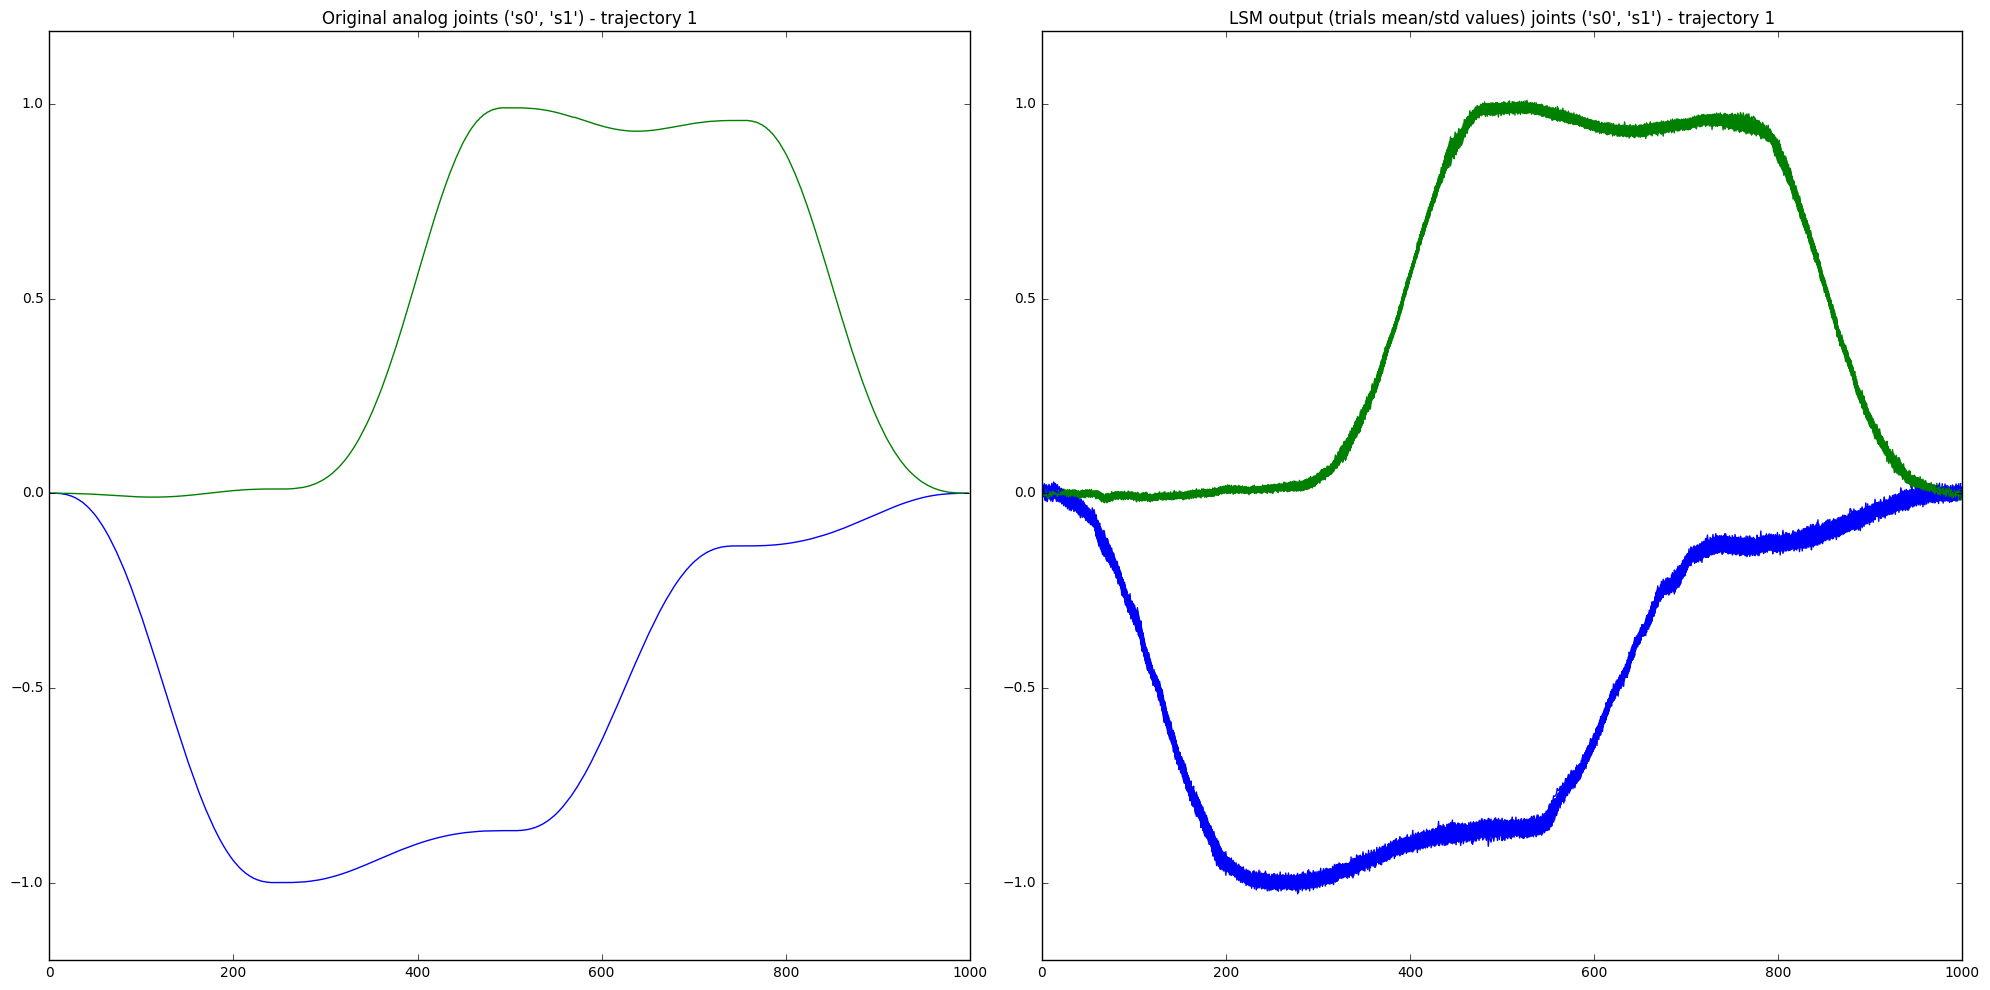

In [147]:
# Plots the inputs and the outputs side-by-side

joints_names = 's0','s1'

y_1 = joints_dict[joints_names[0]][0]
y_2 = joints_dict[joints_names[1]][0]
y1_calculated = joints_dict[joints_names[0]][1]
y2_calculated = joints_dict[joints_names[1]][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset21 = y_2.shape[0]/number_of_trajectories

offset12 = y_1.shape[0]/number_of_trajectories/total_trials
offset22 = y_2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()


    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(y_1[trajectory*(offset11):offset11*trajectory+offset12],'b')
    plt.plot(y_2[trajectory*(offset21):offset21*trajectory+offset22],'g')


    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("Original analog joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    for ci in range(total_trials):
        plt.plot((y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:],'b')    
        plt.plot((y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:],'g')    
    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("LSM output (trials mean/std values) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

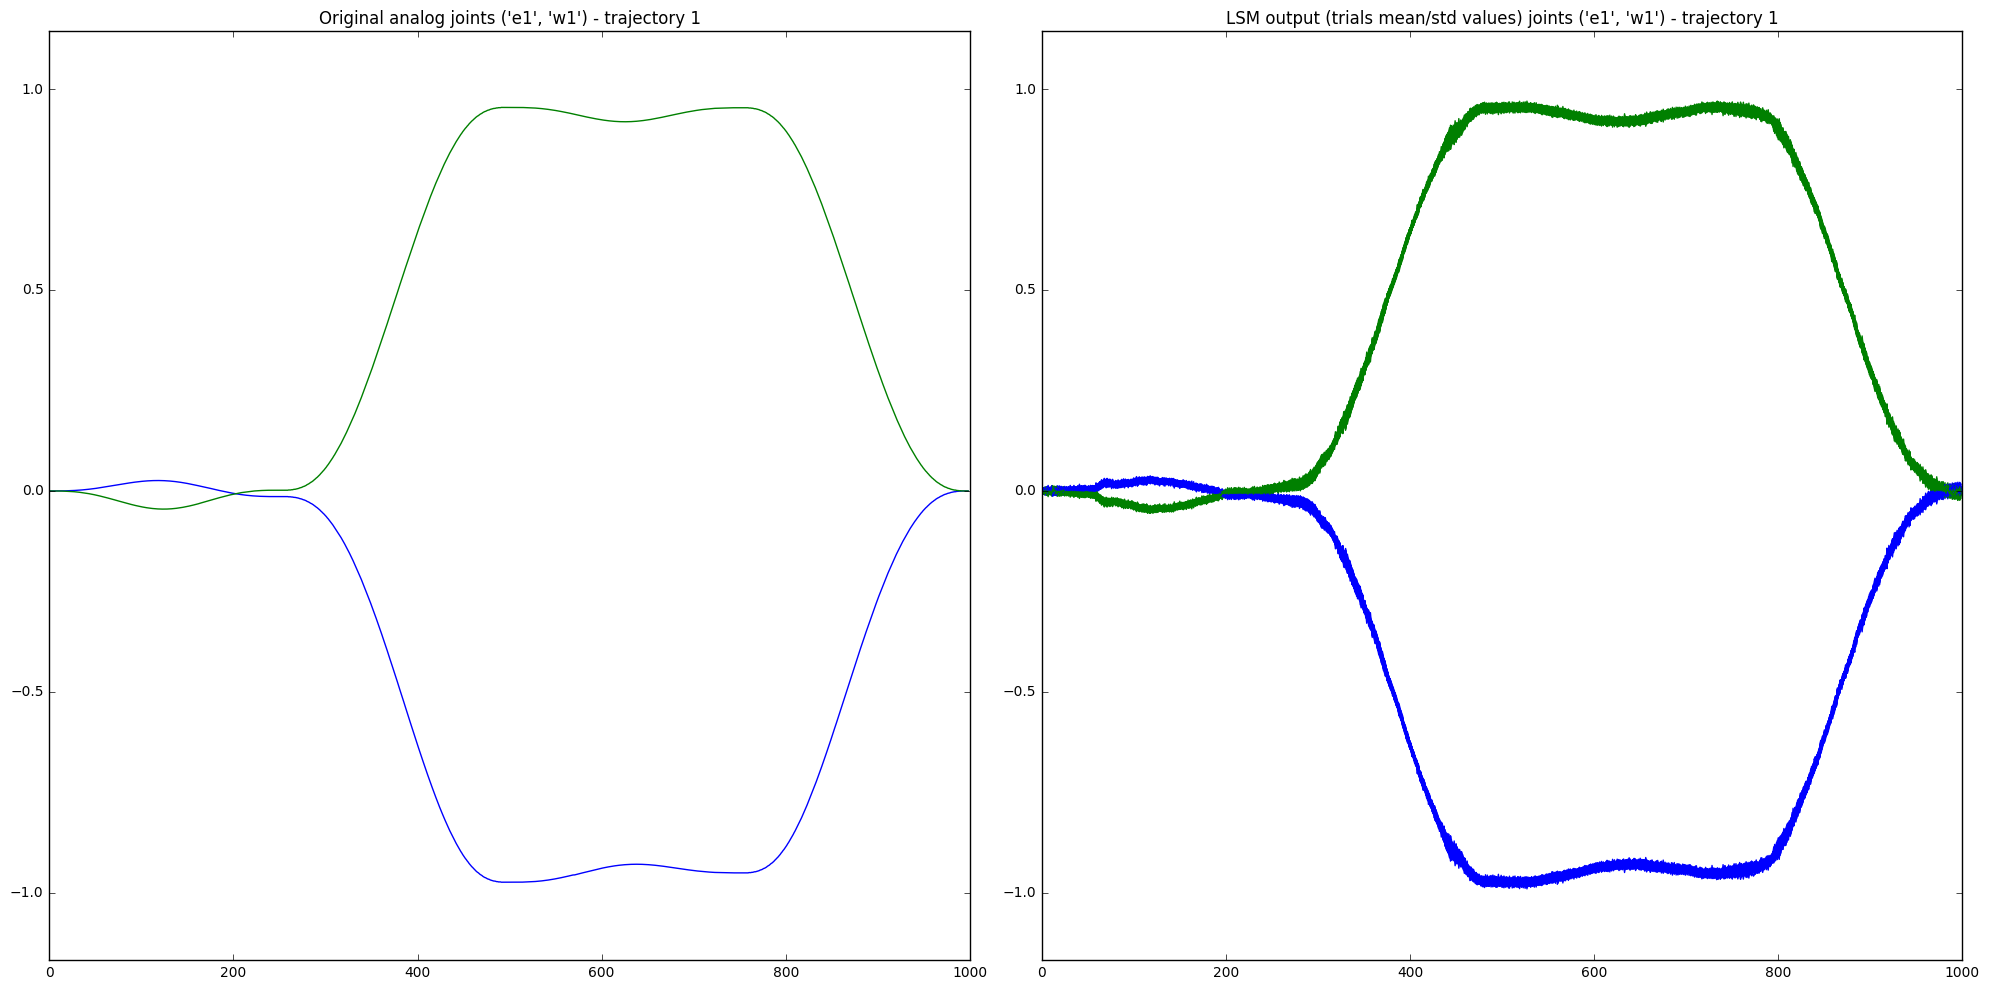

In [148]:
# Plots the inputs and the outputs side-by-side

joints_names = 'e1','w1'

y_1 = joints_dict[joints_names[0]][0]
y_2 = joints_dict[joints_names[1]][0]
y1_calculated = joints_dict[joints_names[0]][1]
y2_calculated = joints_dict[joints_names[1]][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset21 = y_2.shape[0]/number_of_trajectories

offset12 = y_1.shape[0]/number_of_trajectories/total_trials
offset22 = y_2.shape[0]/number_of_trajectories/total_trials


fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y_2[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min(),y2_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()


    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(y_1[trajectory*(offset11):offset11*trajectory+offset12],'b')
    plt.plot(y_2[trajectory*(offset21):offset21*trajectory+offset22],'g')


    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("Original analog joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    for ci in range(total_trials):
        plt.plot((y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:],'b')    
        plt.plot((y2_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:])[ci,:],'g')    
    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("LSM output (trials mean/std values) joints "+ str(joints_names) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

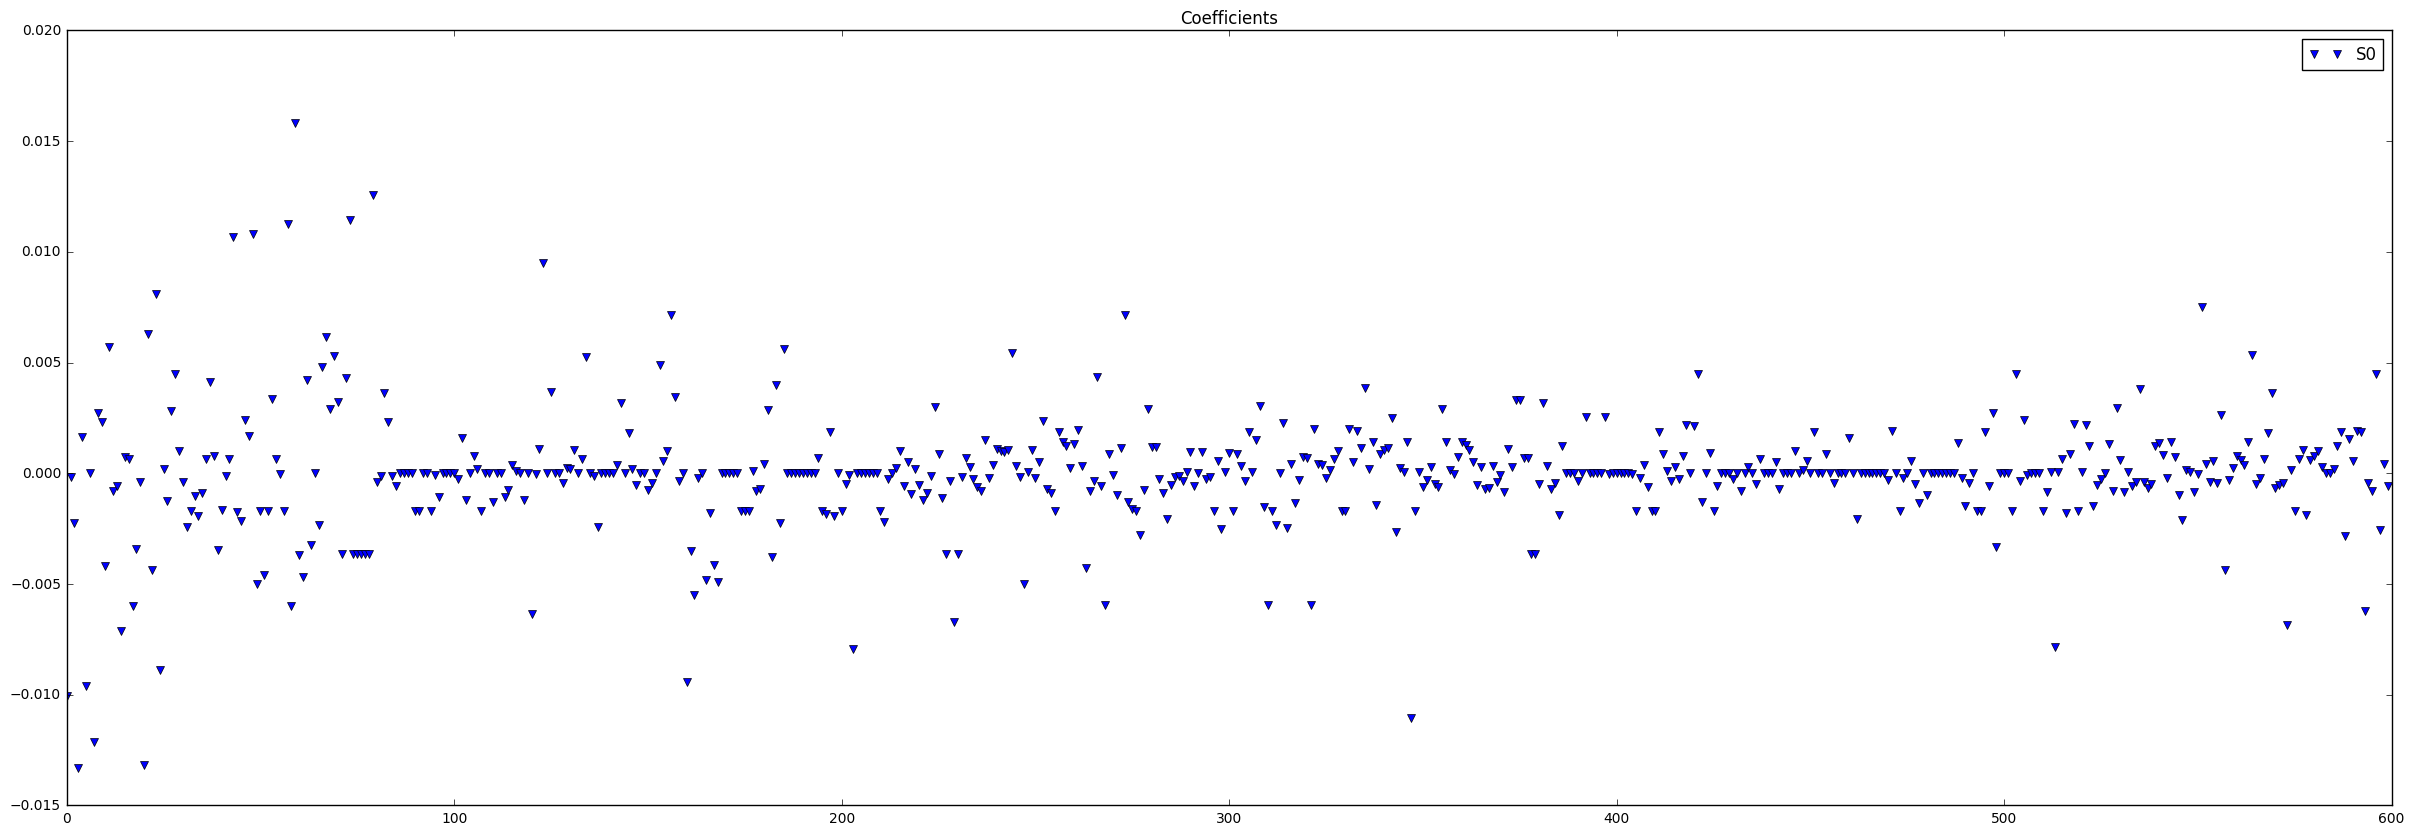

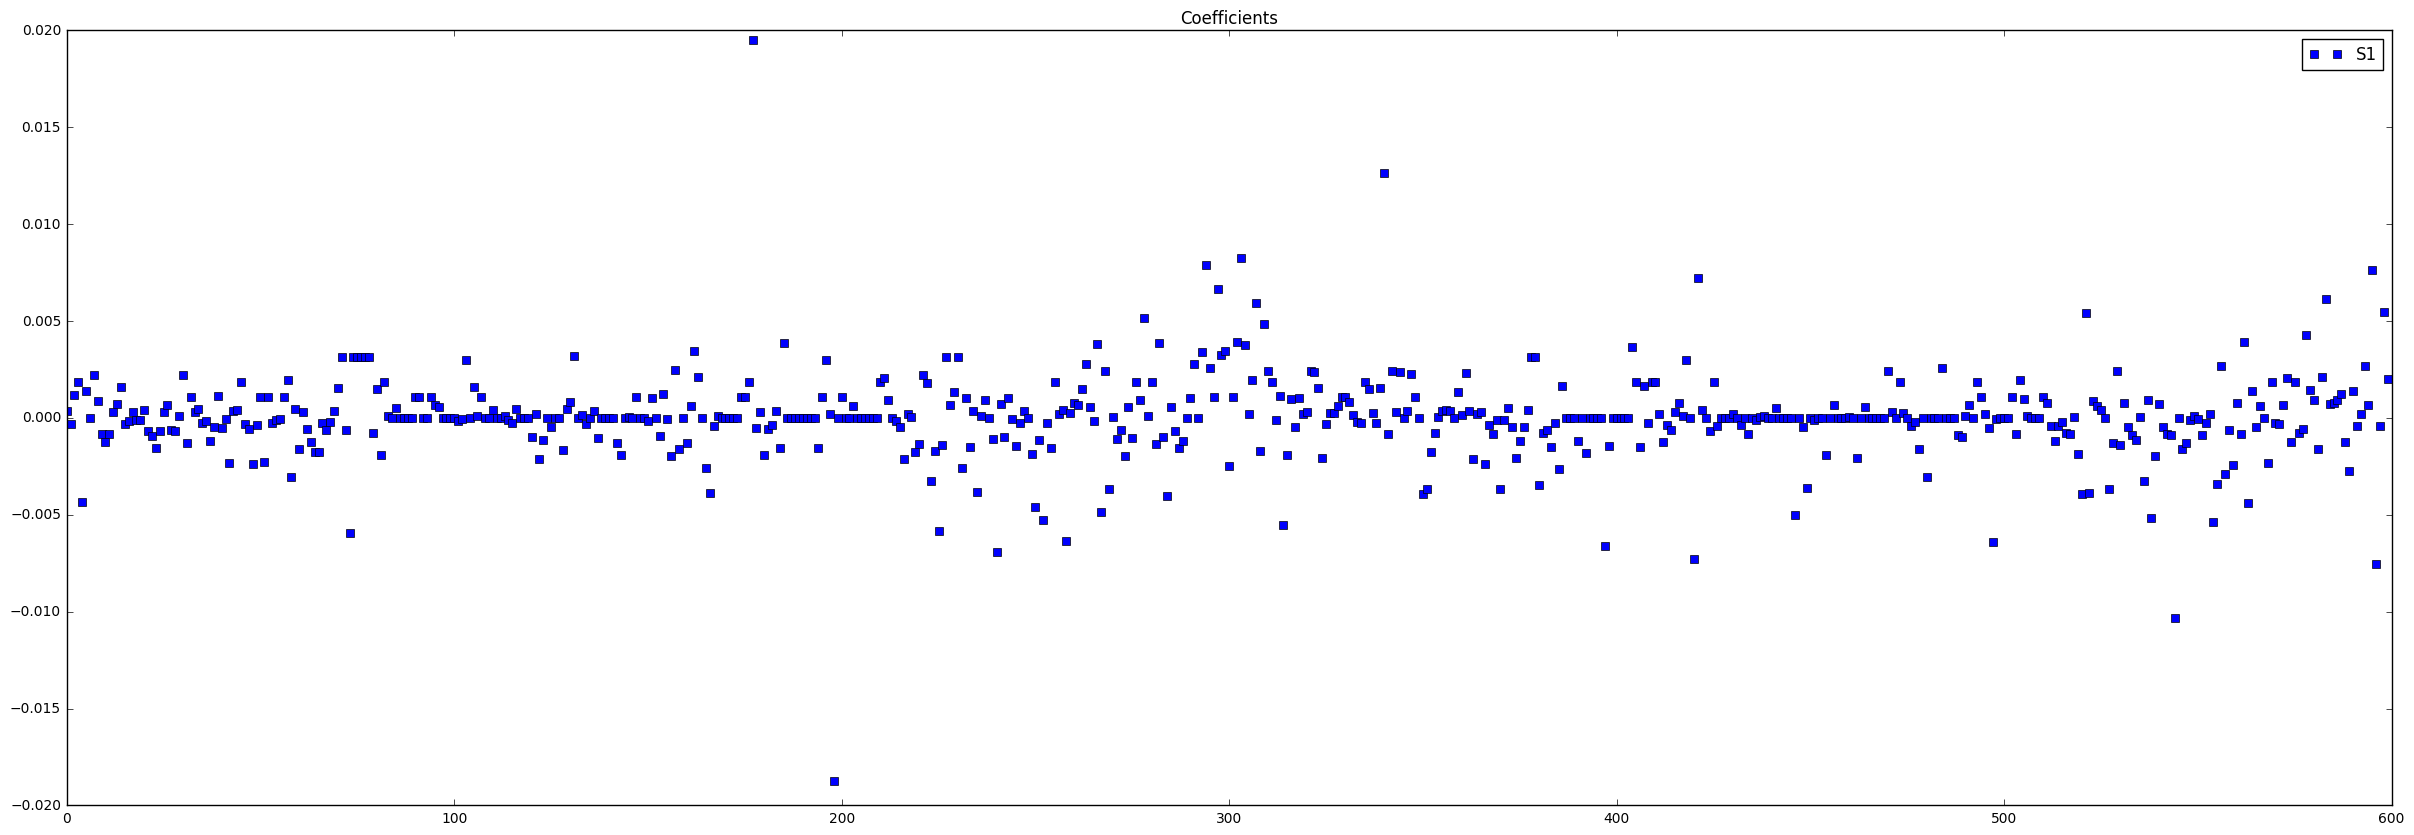

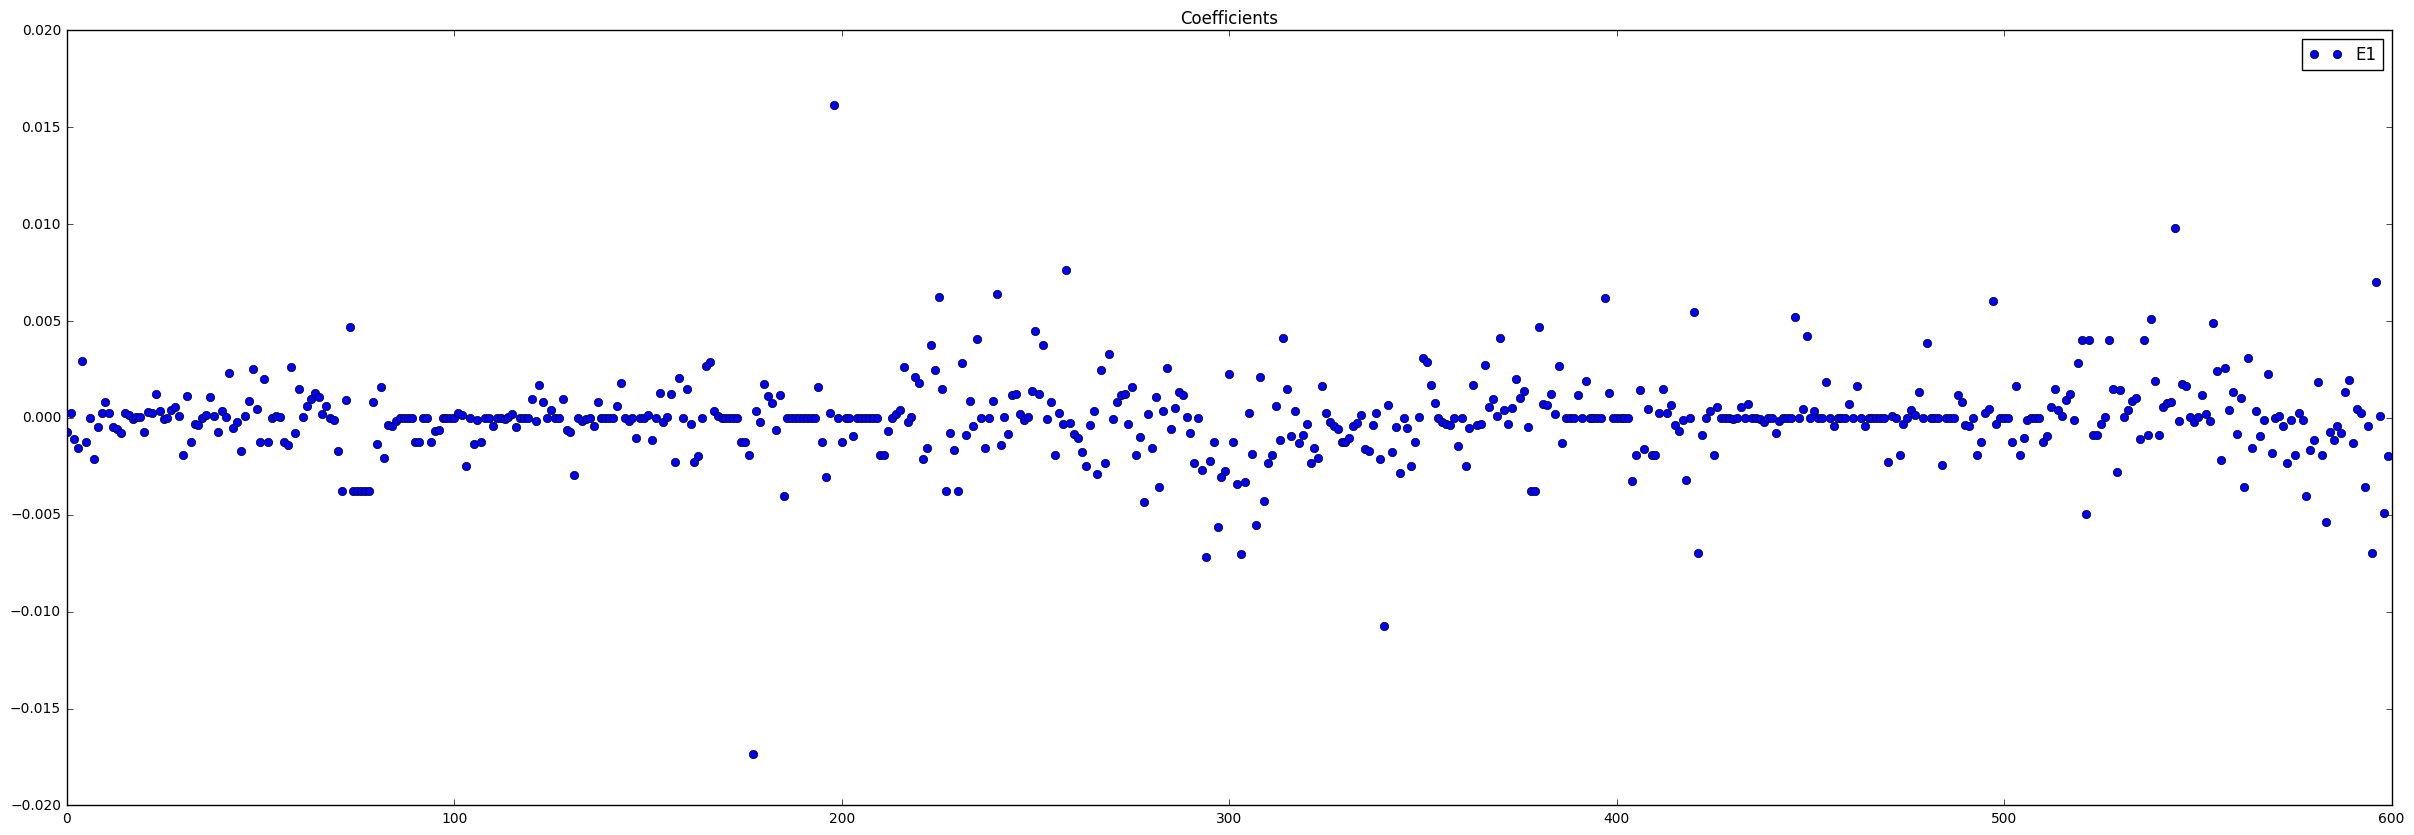

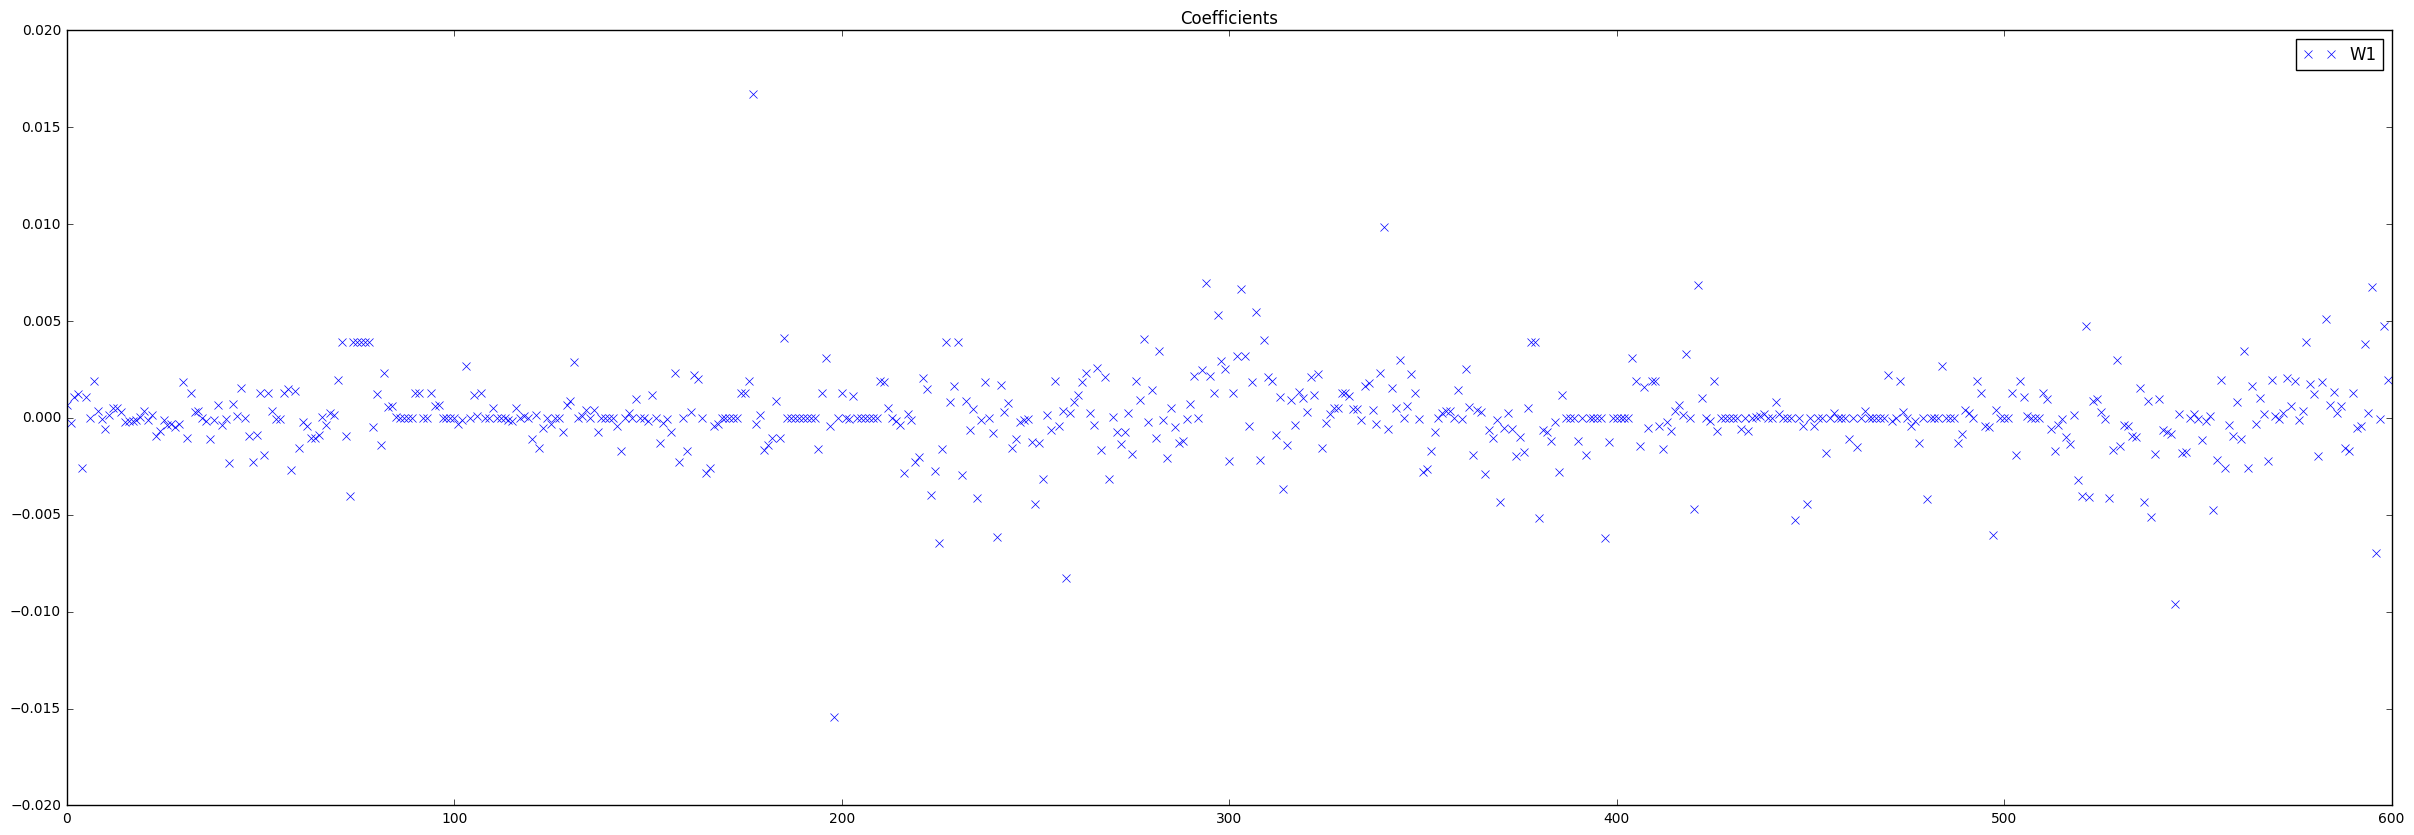

In [149]:
plt.rcParams['figure.figsize'] = 30, 10

# plt.figure(figsize =(30,10))
plt.plot(c_s0,'v',label="S0")
plt.title("Coefficients")
plt.legend()
plt.show()

plt.plot(c_s1,'s',label="S1")
plt.title("Coefficients")
plt.legend()
plt.show()

plt.plot(c_e1,'o',label="E1")
plt.title("Coefficients")
plt.legend()
plt.show()

plt.plot(c_w1,'x',label="W1")
plt.title("Coefficients")
plt.legend()
plt.show()

In [150]:
# Independent terms
r_s0,r_s1,r_e1,r_w1

# Independent terms close to zero are the result of the bias extraction (I force the curves to start at zero)

(-0.0078818886867628724,
 0.0016422158657821706,
 -0.0021963949164894858,
 0.0022142381567893943)

In [151]:
readout_w = [c_s0,c_s1,c_e1,c_w1]
readout_w_n = ['S0','S1','E1','W1'] 

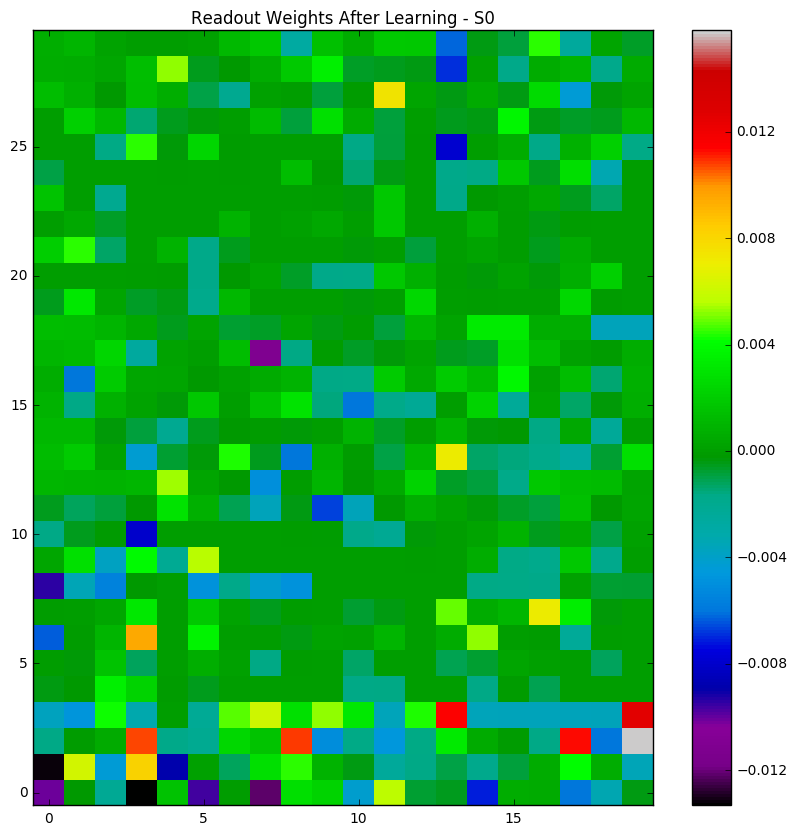

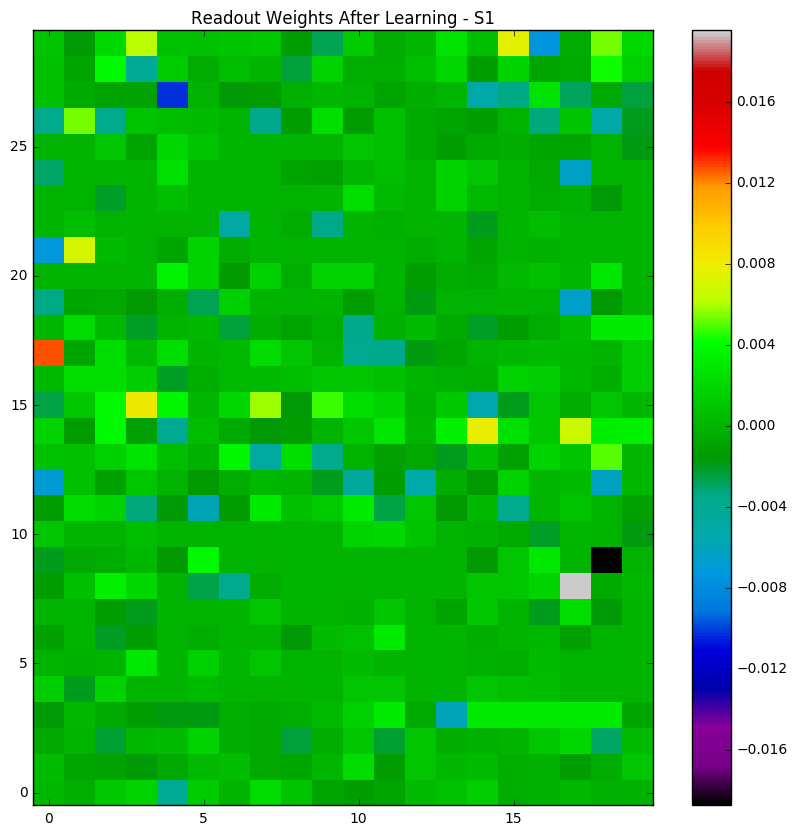

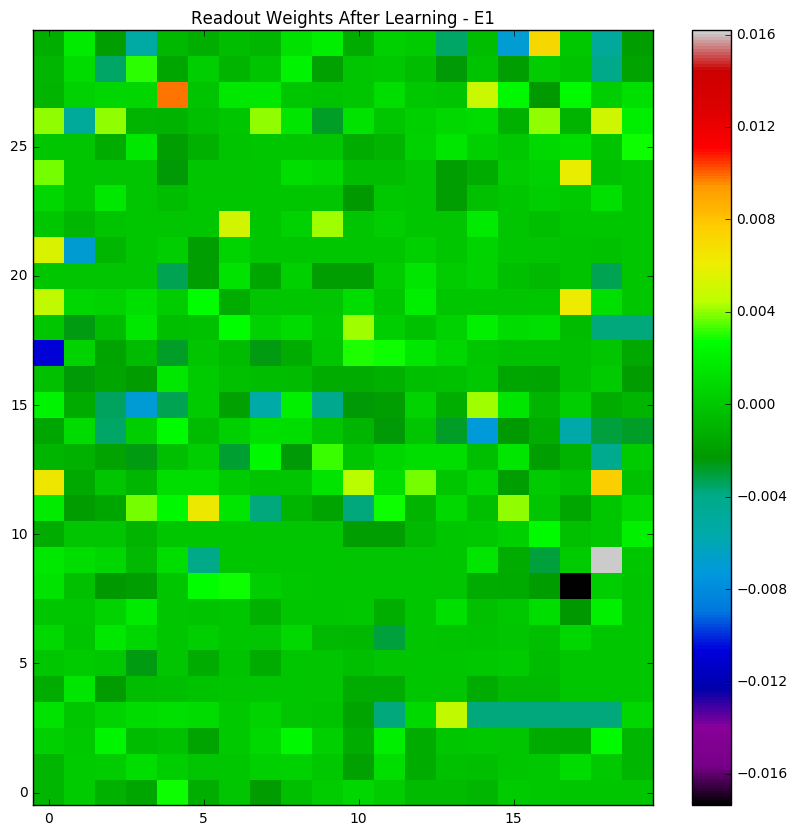

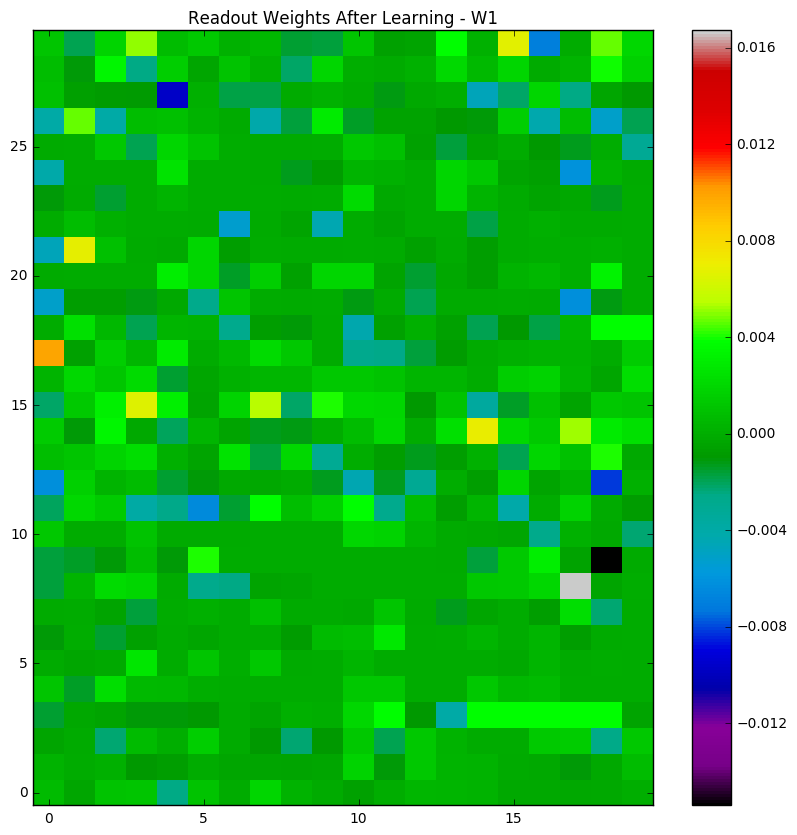

In [152]:
#
# Here the readout weights are plotted as a matrix instead of a line
# to make it easier to visualise / compare their values.
for wi,ti in zip(readout_w,readout_w_n):
    plt.figure(figsize =(10,10))
    plt.imshow(wi.reshape((30,20)), origin='lower', aspect='auto',interpolation='none')
    # plt.axis('off')
    plt.set_cmap('spectral')
    plt.colorbar()
    plt.title("Readout Weights After Learning - "+ti)
    plt.show()